<a href="https://colab.research.google.com/github/Temerius/ML/blob/main/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import dataloader
from torchvision import datasets
from torchvision.transforms import transforms, ToTensor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import random

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
train_data = datasets.MNIST(root='datasets',
                            train=True,
                            transform = ToTensor(),
                            download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 57723920.19it/s]


Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 59264038.07it/s]

Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 31579556.97it/s]


Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2143157.70it/s]

Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw



In [4]:
class_labels = train_data.classes

In [5]:
for i in range(len(class_labels)):
    class_labels[i] = class_labels[i][0]

In [6]:
train_loader = dataloader.DataLoader(dataset=train_data,
                             batch_size=32,
                             shuffle=False
                             )

In [7]:
train_data.data.shape

torch.Size([60000, 28, 28])

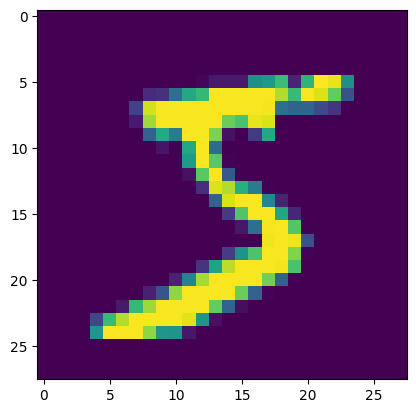

In [8]:
plt.imshow(train_data.data[0].squeeze())

In [9]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 1)
        self.activation = nn.LeakyReLU(0.1)
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return nn.Sigmoid()(x)

In [10]:
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(128, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 784)
        self.activation = nn.ReLU()
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return nn.Tanh()(x)

In [16]:
D = discriminator().to(device)

In [17]:
G = generator().to(device)

In [18]:
D_optimizer =torch.optim.SGD(params = D.parameters(),
                            lr = 0.001)
G_optimizer = torch.optim.SGD(params = G.parameters(),
                            lr = 0.002)

In [19]:
loss = nn.BCELoss()

In [20]:
epochs = 10
for epoch in range(epochs):
    for idx, (imgs, _) in enumerate(train_loader):
        idx += 1

        if idx % 2 == 0:
            real_inputs = imgs.to(device)
            #print(real_inputs.shape)
            real_outputs = D(real_inputs)
            real_label = torch.ones(real_inputs.shape[0], 1).to(device)
            D_loss = loss(real_outputs, real_label)
            D_optimizer.zero_grad()
            D_loss.backward()
            D_optimizer.step()


        noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)
        #outputs = torch.cat((real_outputs, fake_outputs), 0)
        #targets = torch.cat((real_label, fake_label), 0)
        D_loss = loss(fake_outputs, fake_label)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()


        noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        G_loss = loss(fake_outputs, fake_targets)

        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        if idx % 100 == 0 or idx == len(train_loader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))
    if (epoch+1) % 10 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')



Epoch 0 Iteration 100: discriminator_loss 0.676 generator_loss 0.712
Epoch 0 Iteration 200: discriminator_loss 0.684 generator_loss 0.703
Epoch 0 Iteration 300: discriminator_loss 0.693 generator_loss 0.695
Epoch 0 Iteration 400: discriminator_loss 0.702 generator_loss 0.686
Epoch 0 Iteration 500: discriminator_loss 0.708 generator_loss 0.678
Epoch 0 Iteration 600: discriminator_loss 0.718 generator_loss 0.672
Epoch 0 Iteration 700: discriminator_loss 0.719 generator_loss 0.665
Epoch 0 Iteration 800: discriminator_loss 0.721 generator_loss 0.666
Epoch 0 Iteration 900: discriminator_loss 0.721 generator_loss 0.671
Epoch 0 Iteration 1000: discriminator_loss 0.700 generator_loss 0.689
Epoch 0 Iteration 1100: discriminator_loss 0.676 generator_loss 0.713
Epoch 0 Iteration 1200: discriminator_loss 0.654 generator_loss 0.734
Epoch 0 Iteration 1300: discriminator_loss 0.630 generator_loss 0.763
Epoch 0 Iteration 1400: discriminator_loss 0.605 generator_loss 0.787
Epoch 0 Iteration 1500: discr

KeyboardInterrupt: 

In [ ]:
noise = (torch.rand(32, 128)-0.5)/0.5
print(noise)
noise = noise.to(device)
fake_inputs = G(noise)
fake_inputs = fake_inputs.to('cpu')
fake_inputs = fake_inputs.detach().numpy()
fake_inputs[0,0].shape
for i in range(32):
    plt.imshow(fake_inputs[i,0])
    plt.show()